## COSI Temperature correction: manually fitting temperature-binned energy spectra
- Obtain temperatures and energies from data collected over a wide range of temperatures.
- Bin the data by temperature and create one spectrum per bin. 
- Make a plot of peak center energy vs. temperature with a fit for each temperature bin (similar to Carolyn's method but with more points and with energy instead of ADC)

NOTE: 
I use energy instead of ADC here because I'm making one plot for an entire data run, i.e. finding one relationship between peak center and temperature for data collected by all detectors simultaneously. Each strip has a different gain and energy calibration, so a combined spectra plotted in ADC units containing events from all detectors will appear broaded, nonsensical. The peaks will not be resolved. 

So, this is NOT a strip-by-strip calibration like Carolyn did. Because Carolyn looked at each strip individually, she could make plots for each strip in terms of ADC vs. temperature.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# Convert ADC to energy via the provided energy calibration .ecal file
def d_model(ecal):
    file_object = open(str(ecal),"r")
    lines = file_object.readlines()
    model = []; d = {}
    
    for line in lines:
        if line.startswith("CP"):
            det = line.split()[2]; strip = line.split()[3]; side = line.split()[4] 
            key = det+" "+strip+" "+side
        
        if line.startswith("CM"):
            if key in line:
                model = [float(x) for x in line.split()[6:]]
                max_num_coeffs = 5
                if len(model) < max_num_coeffs:
                    model.extend([0]*(max_num_coeffs - len(model)))

                if len(model) > max_num_coeffs:
                    print("You're using a calibration model with more than 5 coefficients. Code isn't updated for that yet. Sorry.")
                d[key] = model
    return d


In [3]:
# Parse an .roa file from a calibration run. Save the energy and temperature of each event. 
def parse_roa(roa,d,e_min,e_max):
    file_object = open(str(roa),"r")
    lines = file_object.readlines()
    
    energies = []
    temp = []
    
    for i in range(len(lines)):
        line = lines[i]
        if line.startswith("UH") and len(line.split()) >= 7:
            det = line.split()[1]; strip = line.split()[2]; side = line.split()[3] 
            key = det+" "+strip+" "+side
            adc = float(line.split()[4])
            #timing = line.split()[5]
            temperature = float(line.split()[6])

            if key not in d.keys():
                continue

            model = d[key]
            energy = model[0] + model[1]*adc + model[2]*adc**2 + model[3]*adc**3 + model[4]*adc**4

            if (energy > e_min and energy < e_max):
                energies.append(energy)
                temp.append(temperature)

    return energies,temp


In [4]:
ecal_file = "/home/jacqueline/nuclearizer/resource/calibration/COSI20/Wanaka/ecal_Wanaka2020_201005.ecal"
e_min = 0
e_max = 2000

d = d_model(ecal_file)

In [5]:
# Define function to fit the peak
def gauss_line(x,a,x0,sigma,b,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b + c*x

In [6]:
### Define function to plot and fit spectra in each temperature bin, with or without corrected energies

def plot_fit_temp_spectra(temp_bin_labels,binned_data,centers,bool_peak,energy,correc=False,correc_params=None):
    
    # Initialize lists to store temperatures, mean peak value
    temp_list = [] 
    mean_list = []
    mean_err_list = []
    
    # filled if correc=True
    corrections = []

    nsubplots = len(temp_bin_labels)
    print(nsubplots)
    nc = 3
    #nr=2
    nr = nsubplots // nc + 1
    #nr += nsubplots % nc
    print(nr)
    #nr=3
    fig, ax = plt.subplots(nrows=nr,ncols=nc,figsize=(20,20))

#     for i in range(nr):
#         for j in range(nc):
    for i in range(nsubplots):  
        row = i//nc
        pos = i % nc
        # running index
        #ridx = i*4+j 
        #temp = temp_bin_labels[ridx]
        temp = temp_bin_labels[i]
        if temp==temp_bin_labels[-1]:
            continue
        temp_list.append(temp) # representative for the bin

        # tmp data to not have needlessly large indexing
        #tmp_y = np.copy(binned_data[0][bool_peak,ridx])
        tmp_y = np.copy(binned_data[0][bool_peak,i])
        tmp_x = np.copy(centers[bool_peak])
        
        #############################
        if correc == True:

            # Apply linear correction
            slope = correc_params[0]/energy;offset = correc_params[1]/energy
            mod = slope*float(temp)+offset
            #print("slope:",slope,"offset:",offset,"temp:",temp,"mod:",mod)
            tmp_x = tmp_x/mod
            #print("newenergy:",tmp_x)
            
            correction = 1./mod
            corrections.append(correction)
        #############################

        # guesses:
        c_guess = (tmp_y[-1]-tmp_y[0])/(tmp_x[-1]-tmp_x[0])

        b_guess = tmp_y[0] - c_guess * tmp_x[0]

        a_guess = np.max(tmp_y - (b_guess + c_guess*tmp_x))

        x0_guess = tmp_x[np.argmax(tmp_y - (b_guess + c_guess*tmp_x))]

        sigma_guess = np.sum(tmp_y - (b_guess + c_guess*tmp_x))/(np.sqrt(2*np.pi)*a_guess)

        # guess array for curvefit
        p0 = [a_guess,x0_guess,sigma_guess,b_guess,c_guess]
        # note the sigma here
        popt,pcov = curve_fit(gauss_line,tmp_x,tmp_y,sigma=np.sqrt(tmp_y),p0=p0)
        x_fit = np.linspace(energy-15,energy+15,500)

#         ax[i,j].step(tmp_x,tmp_y,where='mid',color='black',label='data')
#         ax[i,j].plot(x_fit,gauss_line(x_fit,*popt),label='fit',color='red')
#         ax[i,j].set_title("{}-{} C".format(temp_bin_labels[ridx],temp_bin_labels[ridx+1]))

        ax[row,pos].step(tmp_x,tmp_y,where='mid',color='black',label='data')
        ax[row,pos].plot(x_fit,gauss_line(x_fit,*popt),label='fit',color='red')
        ax[row,pos].set_title("{}-{} C".format(temp_bin_labels[i],temp_bin_labels[i+1]))

        mean = popt[1]; mean_err = np.sqrt(pcov[1,1])
        mean_list.append(mean); mean_err_list.append(mean_err) 
        sigma = popt[2]; sigma_err = np.sqrt(pcov[2,2])
        
    return temp_list,mean_list,mean_err_list,corrections

In [28]:
from matplotlib.ticker import FuncFormatter

def form3(y, pos):
    return '%.2f'%y

formatter = FuncFormatter(form3)

### Define function to plot the centers from each fit against temperature

def plot_center_vs_temp_scatter(temp_bin_centers,mean_list,mean_err_list,source,correc=False):
    fig = plt.figure(figsize=(7,7))

    # or should I be plotting against temp_list_<source>?
#     plt.errorbar(temp_bin_centers,mean_list_corr_Cs,
#              xerr=np.repeat(0.5,len(temp_bin_centers)),yerr=mean_err_list_corr_Cs,
#              fmt='.',color='k')

    ax = fig.add_subplot(111)

    ax.errorbar(temp_bin_centers,mean_list,
                 xerr=np.repeat(temp_bin_width/2,len(temp_bin_centers)),yerr=mean_err_list,
                 fmt='.',color='k')

    def linear(x,a,b):
        return a*x + b

    a_guess = -1
    b_guess = temp_bin_centers[0]

    p0 = [a_guess,b_guess]
    popt,pcov = curve_fit(linear,temp_bin_centers,mean_list,sigma=np.sqrt(mean_list),p0=p0)
    x_fit = np.linspace(min(temp_bin_centers)-1, max(temp_bin_centers)+1, 100)

    slope = popt[0];offset = popt[1]
    slope_err = np.sqrt(pcov[0,0]);offset_err=np.sqrt(pcov[1,1])
    
    ax.plot(x_fit,linear(x_fit,*popt),label='Fit: E = ({} $\pm$ {})T + {} $\pm$ {}'
             .format("%.2f"%slope,"%.2f"%slope_err,"%.1f"%offset,"%.1f"%offset_err),color='red')

    plt.legend(loc='best',fontsize=14)

    # disable scientific notation on axes
  #  plt.ticklabel_format(style="plain",useOffset=False)
    
    ax.set_xlabel("Temperature [$^\circ$C]",fontsize=14)
    #plt.xticks(fontsize=14)
    #plt.yticks(fontsize=14)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formatter))
    ax.tick_params(axis='both', labelsize=14)#  set_xtick_labels(fontsize=14)
    
#     # disable scientific notation on axes
#     plt.ticklabel_format(style="plain",useOffset=False)
    
    
    if correc==True:
        plt.ylabel("Corrected peak energy [keV]",fontsize=14)
        #plt.title("Corrected {} peak energy vs. Temperature".format(source),fontsize=15)
        plt.savefig('/volumes/eos/users/jacqueline/EnergyRes_Wanaka2020/CrossTalkCorrection_rofl/TempCorr2020_Y88_898keV_centroids_corrected.pdf', bbox_inches='tight')

    else:
        plt.ylabel("Peak energy [keV]",fontsize=14)
        #plt.title(" {} peak energy vs. Temperature".format(source),fontsize=15)
        plt.savefig('/volumes/eos/users/jacqueline/EnergyRes_Wanaka2020/CrossTalkCorrection_rofl/TempCorr2020_Y88_898keV_centroids.pdf', bbox_inches='tight')

        
    return slope,slope_err,offset,offset_err

# Y-88

In [8]:
roa_path = "/volumes/eos/users/jacqueline/EnergyCalib_Wanaka2020/Y88/"
roa_file = ["BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa00", \
           "BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa01", \
           "BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa02", \
           "BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa06", \
          "BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa07", \
          "BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa10"]

energies = []
temp = []
for i in roa_file:
    print(i)
    roa = roa_path + i
    e,t = parse_roa(roa,d,e_min,e_max)
    energies.extend(e)
    temp.extend(t)

print("Minimum energy [keV]:",min(energies),"Maximum energy [keV]:",max(energies))
print("Minimum temp [C]:",min(temp),"Maximum temp [C]:",max(temp))

BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa00
BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa01
BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa02
BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa06
BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa07
BD_COSI_GCUcalib-200312_231900-200313_035600-Y88split.roa10
Minimum energy [keV]: 14.078481234483199 Maximum energy [keV]: 1999.986462932998
Minimum temp [C]: 25.991 Maximum temp [C]: 31.6743


In [10]:
df = pd.DataFrame({'Energy':energies,'PreampTemp':temp})

In [11]:
temp_bin_width = 0.35
temp_bins = np.arange(df["PreampTemp"].min(),df["PreampTemp"].max()+temp_bin_width,temp_bin_width)
temp_bin_labels = [str(round(i,2)) for i in temp_bins]
print(temp_bins)
print(temp_bin_labels)

[25.991 26.341 26.691 27.041 27.391 27.741 28.091 28.441 28.791 29.141
 29.491 29.841 30.191 30.541 30.891 31.241 31.591 31.941]
['25.99', '26.34', '26.69', '27.04', '27.39', '27.74', '28.09', '28.44', '28.79', '29.14', '29.49', '29.84', '30.19', '30.54', '30.89', '31.24', '31.59', '31.94']


In [29]:
# Define energy bins
energy_min = 600
energy_max = 1200
energy_bins = np.linspace(energy_min,energy_max,1800)

energy = 898.042 # true keV


# energy_min = 1500
# energy_max = 2100
# energy_bins = np.linspace(energy_min,energy_max,1800)

# energy = 1836.063 # true keV

In [30]:
binned_data = np.histogram2d(df['Energy'].values,
                             df['PreampTemp'].values,
                             bins=(energy_bins,temp_bins))

In [31]:
# Define boolean to select photopeak
bool_peak = np.where((energy_bins >= 892) & (energy_bins <= 904))[0]
#bool_peak = np.where((energy_bins >= 1830) & (energy_bins <= 1842))[0]

# Fit the spectrum in each temperature bin
centers = (0.5*(energy_bins[0:-1] + energy_bins[1:]))

In [32]:
c_guess = (binned_data[0][bool_peak,1][-1]-binned_data[0][bool_peak,1][0])/\
          (centers[bool_peak][-1]-centers[bool_peak][0])

b_guess = binned_data[0][bool_peak,1][0] - c_guess * centers[bool_peak][0]

In [33]:
a_guess = np.max(binned_data[0][bool_peak,1] - (b_guess + c_guess*centers[bool_peak]))

x0_guess = centers[bool_peak][np.argmax(binned_data[0][bool_peak,1] - (b_guess + c_guess*centers[bool_peak]))]

In [34]:
sigma_guess = np.sum(binned_data[0][bool_peak,1] - (b_guess + c_guess*centers[bool_peak]))/\
              (np.sqrt(2*np.pi)*a_guess)

18
7


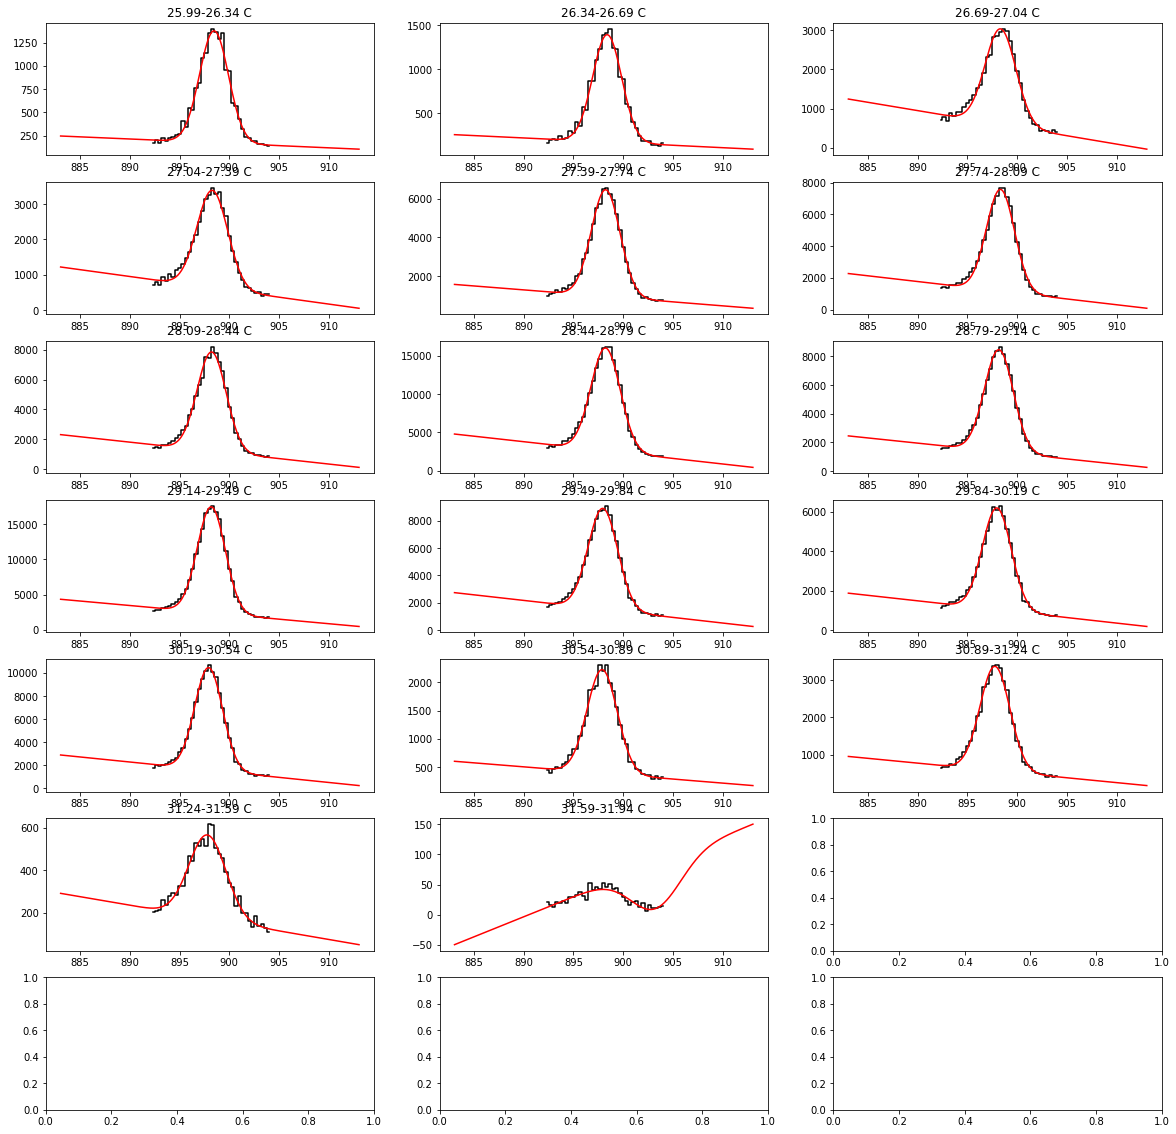

In [35]:
# Fit the temperature-binned peaks 
temp_list,mean_list,mean_err_list,_ = plot_fit_temp_spectra(temp_bin_labels,binned_data,centers,bool_peak,energy)

In [36]:
## Choose the mean between bin edges as representative for the temperature
#temp_bin_centers = 0.5*(temp_bins[0:-1]+temp_bins[1:])

temp_bin_centers = [0.5*(temp_bins[i]+temp_bins[i+1]) for i in range(len(temp_bins)-1)]
print(temp_bin_centers)

[26.166, 26.516000000000002, 26.866000000000003, 27.216000000000005, 27.566000000000006, 27.916000000000007, 28.26600000000001, 28.61600000000001, 28.96600000000001, 29.316000000000013, 29.666000000000015, 30.016000000000016, 30.366000000000017, 30.71600000000002, 31.06600000000002, 31.41600000000002, 31.766000000000023]


[26.166, 26.516000000000002, 26.866000000000003, 27.216000000000005, 27.566000000000006, 27.916000000000007, 28.26600000000001, 28.61600000000001, 28.96600000000001, 29.316000000000013, 29.666000000000015, 30.016000000000016, 30.366000000000017, 30.71600000000002, 31.06600000000002, 31.41600000000002, 31.766000000000023]
[26.166, 26.516000000000002, 26.866000000000003, 27.216000000000005, 27.566000000000006, 27.916000000000007, 28.26600000000001, 28.61600000000001, 28.96600000000001, 29.316000000000013, 29.666000000000015, 30.016000000000016, 30.366000000000017, 30.71600000000002, 31.06600000000002, 31.41600000000002]


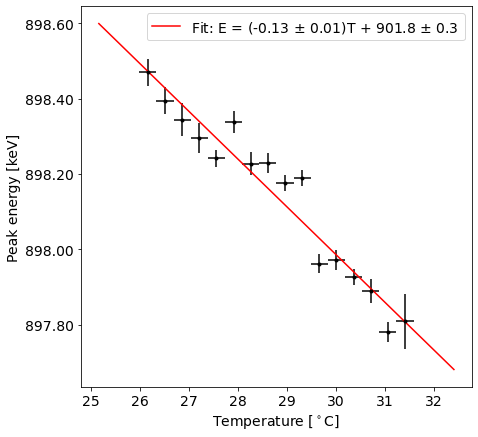

In [37]:
## Plot the centers of each fit against temperature

# # 898 keV: manually remove bad fits
unwanted = [-1] 
print(temp_bin_centers)
for ele in sorted(unwanted, reverse = True):  
    del temp_bin_centers[ele]
    del mean_list[ele]
    del mean_err_list[ele]
    

# # # 1836 keV: manually remove bad fits
# unwanted = [0,15,16] 
# print(temp_bin_centers)
# for ele in sorted(unwanted, reverse = True):  
#     del temp_bin_centers[ele]
#     del mean_list[ele]
#     del mean_err_list[ele]
    
print(temp_bin_centers)
slope,slope_err,offset,offset_err = plot_center_vs_temp_scatter(temp_bin_centers,mean_list,mean_err_list,source="Y-88",correc=False)


-0.12670673681797417 901.7881637014966
0.008952563880907963 0.2581609897999246
18
7


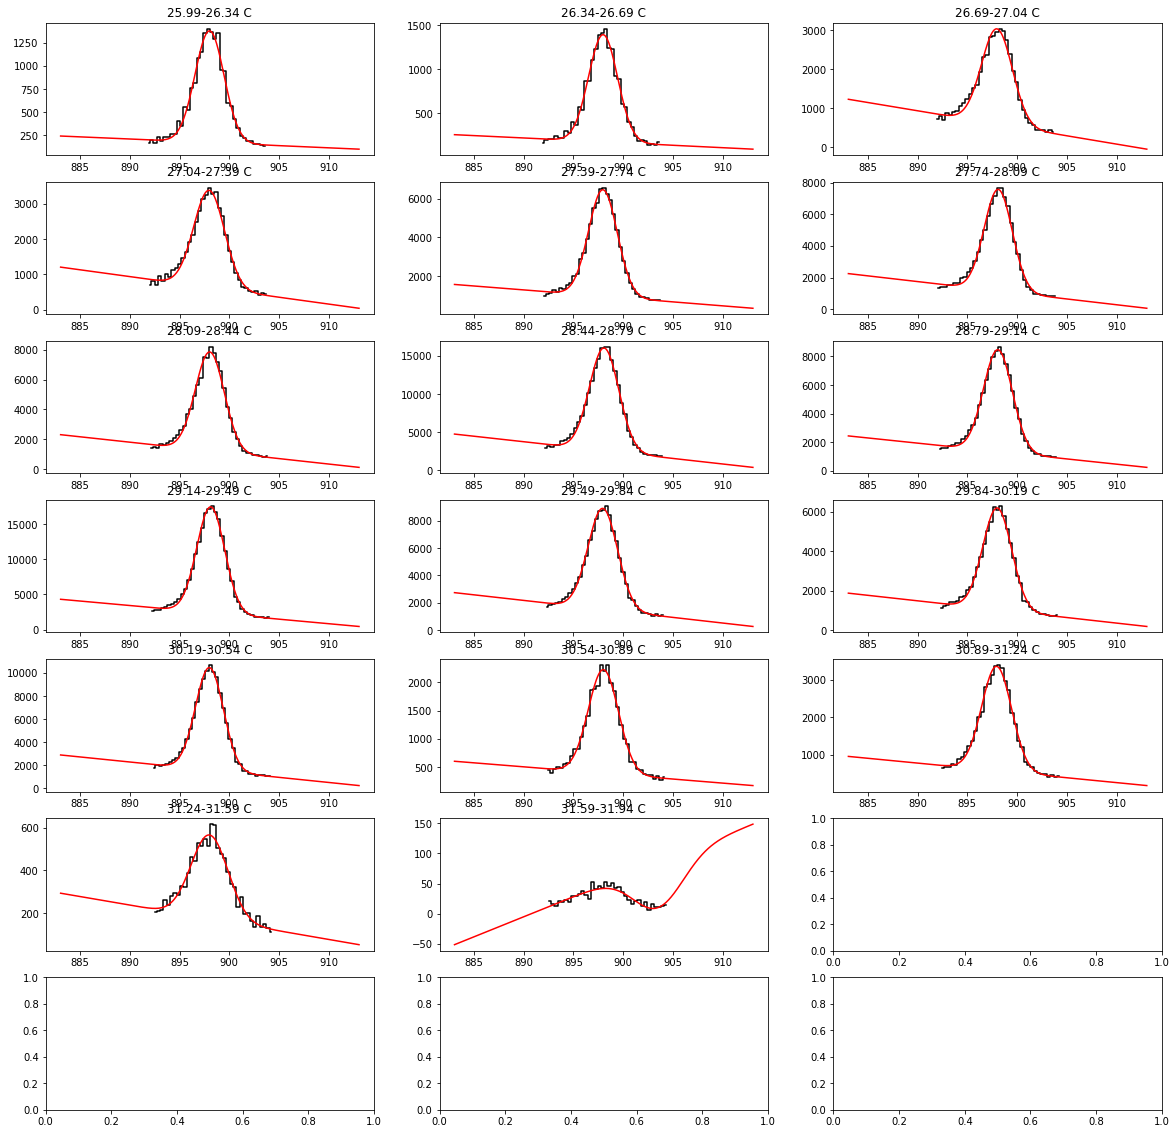

In [38]:
# Correct the spectra and re-fit
print(slope,offset)
print(slope_err,offset_err)
# Fit the temperature-binned peaks with corrected energies
temp_list_corr,mean_list_corr,mean_err_list_corr,corrections = plot_fit_temp_spectra(temp_bin_labels,
                                                                                                 binned_data,centers,bool_peak,energy,
                                                                                                 correc=True,correc_params=[slope,offset])

[26.166, 26.516000000000002, 26.866000000000003, 27.216000000000005, 27.566000000000006, 27.916000000000007, 28.26600000000001, 28.61600000000001, 28.96600000000001, 29.316000000000013, 29.666000000000015, 30.016000000000016, 30.366000000000017, 30.71600000000002, 31.06600000000002, 31.41600000000002]


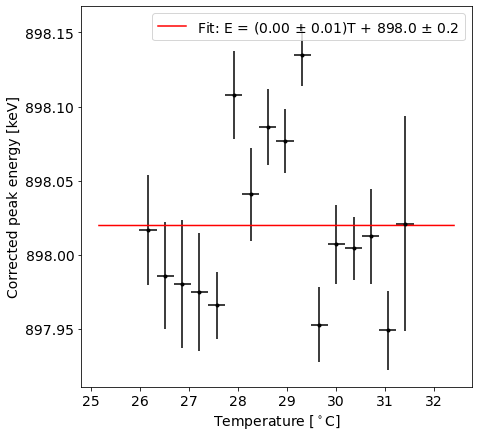

In [39]:
# manually remove bad fits
print(temp_bin_centers)

# # 898 keV
unwanted_corr = [-1] 

# 1836 keV
#unwanted_corr = [0,15, 16] 

for ele in sorted(unwanted_corr, reverse = True):  
#    del temp_list_corr[ele]
    del mean_list_corr[ele]
    del mean_err_list_corr[ele]

## Plot the centers of each corrected fit against temperature
slope_corr,slope_err_corr,offset_corr,offset_err_corr = plot_center_vs_temp_scatter(temp_bin_centers,mean_list_corr,mean_err_list_corr,source="Y-88",correc=True)


In [ ]:
# # Make the text file for nuclearizer
# f = open("/volumes/eos/users/jacqueline/EnergyRes_Wanaka2020/CrossTalkCorrection_rofl/Y88/temp_corr/TempCalibration_Y88_1836keV_200817.txt","w")
# num_dets = 12
# num_strips = 37
# num_sides = 2

# P1 = slope / energy
# P0 = offset / energy

# for det in range(num_dets):
#     for side in range(num_sides):
#         for strip in range(1,num_strips+1):
#             f.write("CT dss "+str(det)+" "+str(strip)+" "+str(side)+" "+str(P0)+" "+str(P1))
#             f.write("\n")
# f.close()